In [28]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Load the data
news_data = pd.read_csv('../data/raw_analyst_ratings.csv')
stock_data = pd.read_csv('../data/AAPL_historical_data.csv')

# Parse dates
news_data['date'] = pd.to_datetime(news_data['date'], errors='coerce')
stock_data['Date'] = pd.to_datetime(stock_data['Date'], errors='coerce')

# Remove timezone information to make both timezone-naive
news_data['date'] = news_data['date'].dt.tz_localize(None)
stock_data['Date'] = stock_data['Date'].dt.tz_localize(None)


analyzer = SentimentIntensityAnalyzer()
news_data['sentiment'] = news_data['headline'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Aggregate sentiment by date
daily_sentiment = news_data.groupby(news_data['date'])['sentiment'].mean().reset_index()
# Optionally, fill or drop missing values if necessary
daily_sentiment = daily_sentiment.dropna()
stock_data = stock_data.dropna()

# Calculate daily stock returns
stock_data['daily_return'] = stock_data['Close'].pct_change()

# Merge sentiment data with stock data
# Perform the merge again after ensuring both DataFrames have valid dates
merged_data = pd.merge(daily_sentiment, stock_data, left_on='date', right_on='Date')

# Drop rows with missing data in the merged DataFrame
merged_data = merged_data.dropna(subset=['sentiment', 'daily_return'])

# Recheck if there are any valid rows
print("Merged Data Info:")
print(merged_data.info())
# Strip time information and ensure both columns are of the same type
daily_sentiment['date'] = daily_sentiment['date'].dt.date
stock_data['Date'] = stock_data['Date'].dt.date

print("Sentiment Date Range:", daily_sentiment['date'].min(), "to", daily_sentiment['date'].max())
print("Stock Date Range:", stock_data['Date'].min(), "to", stock_data['Date'].max())


Merged Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          0 non-null      datetime64[ns]
 1   sentiment     0 non-null      float64       
 2   Date          0 non-null      datetime64[ns]
 3   Open          0 non-null      float64       
 4   High          0 non-null      float64       
 5   Low           0 non-null      float64       
 6   Close         0 non-null      float64       
 7   Adj Close     0 non-null      float64       
 8   Volume        0 non-null      int64         
 9   Dividends     0 non-null      float64       
 10  Stock Splits  0 non-null      float64       
 11  daily_return  0 non-null      float64       
dtypes: datetime64[ns](2), float64(9), int64(1)
memory usage: 132.0 bytes
None
Sentiment Date Range: 2011-04-27 to 2020-06-11
Stock Date Range: 1980-12-12 to 2024-07-30


In [29]:
print("Daily aggregate of  Sentiment Data:")
print(daily_sentiment.head())
print(daily_sentiment.info())

print("Stock Data:")
print(stock_data.head())
print(stock_data.info())
print("Sentiment Date Type:", daily_sentiment['date'].dtype)
print("Stock Date Type:", stock_data['Date'].dtype)

print("Daily Sentiment Missing Values:")
print(daily_sentiment.isna().sum())

print("Stock Data Missing Values:")
print(stock_data.isna().sum())

# Optionally, fill or drop missing values if necessary
daily_sentiment = daily_sentiment.dropna()
stock_data = stock_data.dropna()
# Perform the merge again after ensuring both DataFrames have valid dates
merged_data = pd.merge(daily_sentiment, stock_data, left_on='date', right_on='Date')

# Drop rows with missing data in the merged DataFrame
merged_data = merged_data.dropna(subset=['sentiment', 'daily_return'])

# Recheck if there are any valid rows
print("Merged Data Info:")
print(merged_data.info())

# Print a few rows from each DataFrame for inspection
print("Daily Sentiment Sample:")
print(daily_sentiment.head())

print("Stock Data Sample:")
print(stock_data.head())

# Calculate correlation between sentiment and daily return
correlation = merged_data[['sentiment', 'daily_return']].corr().iloc[0, 1]
print(f"Correlation between sentiment and daily return: {correlation:.2f}")


Daily aggregate of  Sentiment Data:
         date  sentiment
0  2011-04-27     0.0000
1  2011-04-28     0.0000
2  2011-04-28     0.2500
3  2011-04-29     0.0000
4  2011-04-29     0.7351
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36011 entries, 0 to 36010
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       36011 non-null  object 
 1   sentiment  36011 non-null  float64
dtypes: float64(1), object(1)
memory usage: 562.8+ KB
None
Stock Data:
         Date      Open      High       Low     Close  Adj Close     Volume  \
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.098943  469033600   
1  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093781  175884800   
2  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086898  105728000   
3  1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089049   86441600   
4  1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091630   73449600   



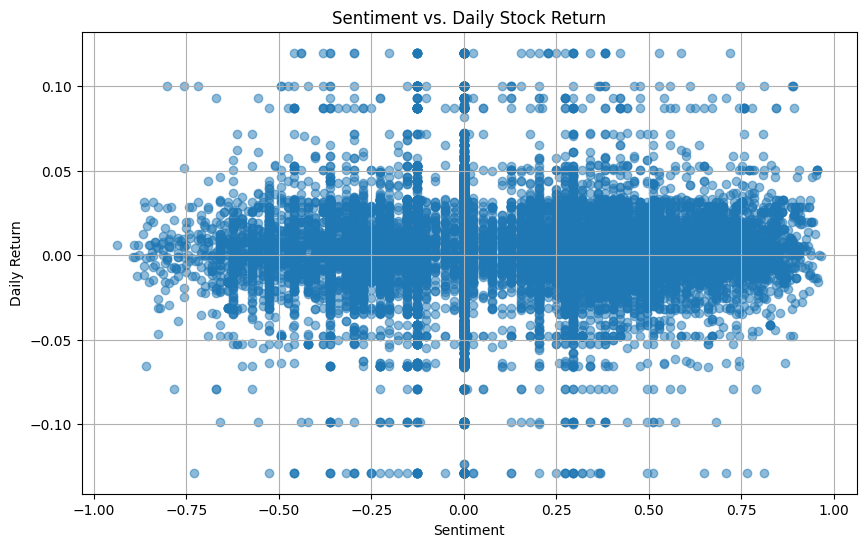

In [30]:
import matplotlib.pyplot as plt

# Scatter plot of sentiment vs daily return
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['sentiment'], merged_data['daily_return'], alpha=0.5)
plt.title('Sentiment vs. Daily Stock Return')
plt.xlabel('Sentiment')
plt.ylabel('Daily Return')
plt.grid(True)
plt.show()


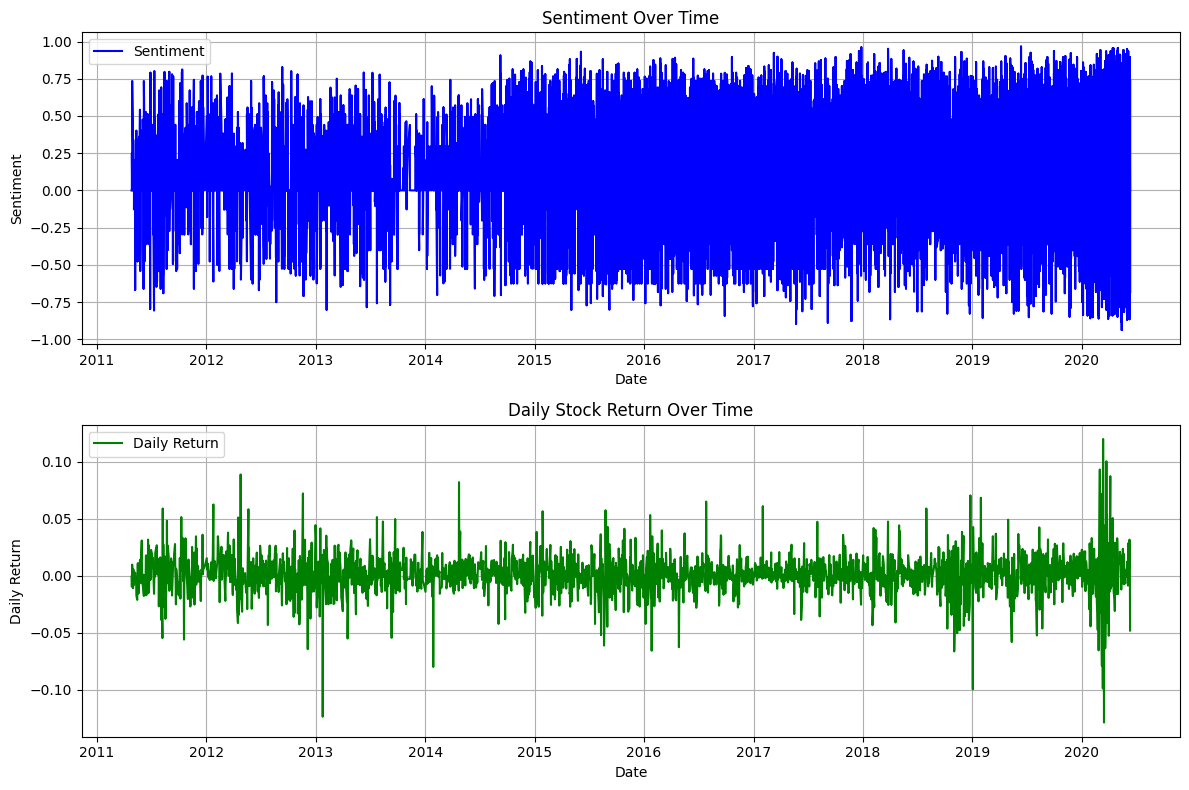

In [31]:
plt.figure(figsize=(12, 8))

# Plot sentiment
plt.subplot(2, 1, 1)
plt.plot(merged_data['date'], merged_data['sentiment'], color='blue', label='Sentiment')
plt.title('Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.legend()
plt.grid(True)

# Plot daily return
plt.subplot(2, 1, 2)
plt.plot(merged_data['date'], merged_data['daily_return'], color='green', label='Daily Return')
plt.title('Daily Stock Return Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


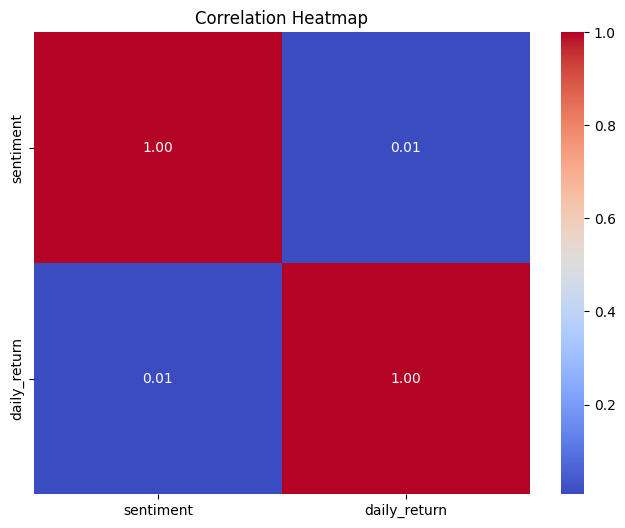

In [33]:
import seaborn as sns

# Create a heatmap for correlation
plt.figure(figsize=(8, 6))
correlation_matrix = merged_data[['sentiment', 'daily_return']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()